# Individual Income Tax Prediction

## Overview

After the tax reform recently, articles and analysis about tax are everywhere. Working as a tax analyst, I conduct data analysis over financial data every day for tax purposes, but I still find it is a pain to fill out my own individual tax return every year. You might think we can use Turbo tax or other tax preparation software to get them done, but were you ever curious about the amount you paid compared to others. Did you pay more than others or less? How’s the tax payment distribution amount US like? There are also people who have income other than salary need to figure out how much estimated tax they should pay by the end of the year to avoid fines and penalties. 

US has a very complicated tax system that not everyone has time to fully understand. Errors might happen when people type in or write down the wrong amount, and no one wants to be audited or get penalties from IRS. There is no benchmark for people to estimate their tax, other than their previous year return. What should we do if this is the first year return? What should we do if our income structure changes completely? How to minimize the potential errors? IRS has the database of the tax information in US for the past several years. If we have a model that can predict roughly about how much tax we owe each year, we will be able to understand if we need to pay estimate tax or if there might be some potential errors. 

## Problem Statement

As discussed above, it is hard for each individual to understand how much tax they need to pay each year. People are vulnerable if they do not know if they need to pay an estimate tax or if they have paid the right amount. How to avoid these situations? The potential solution is to build up a model to estimate how much tax they should pay. In this way, there will be a benchmark for people to compare to so that they know if there are abnormal amount caused by errors or other factors.

## Metrics

There are many simple free models online, such as [smart assets]( https://smartasset.com/taxes/income-taxes), that can be used as a benchmark. However, since similar models only take salary into account, the amount my model calculated could be different from them. We can use the real data from IRS to test the free model online and my model. The less difference between calculated amount and the real amount, the better the model is. This is more a regression model other than a classification model, so the percentage of differences can be a good measure.


## Dataset

The dataset can be found in [Kaggle](https://www.kaggle.com/irs/individual-income-tax-statistics/data) or [IRS](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi). It is saved separately as csv files for analysis. The detail information about column name and explanation can be found in "field_definitions.csv" file. Detail information can also be found in [IRS](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi). The original dataset is not consistent each year, so I will only use the following columns for this analysis. I have manipulate them to make it easiler to understand. The number in the original dataset is the total amount per zipcode.

* state - 2 letter state abbreviation
* agi_class
* num_of_returns - number of returns
* num_of_exemptions - number total exemptions
* num_of_dependents - number of total dependents
* num_of_itemized - total number of returns with itemized deduction
* agi - AGI
* total_salary - total amount of salaries & wages
* taxable_interest - total amount of taxable interest
* ordinary_dividend - total amount of ordinary dividend
* net_capital_gl - net amount of capital gain/loss
* total_tax - Total income tax amount
* prep - Number of returns using a Paid Preparer

AGI_Stub information shows below:

* 1 = \$1 under \$25,000 
* 2 = \$25,000 under \$50,000 
* 3 = \$50,000 under \$75,000 
* 4 = \$75,000 under \$100,000 
* 5 = \$100,000 under \$200,000 
* 6 = \$200,000 or more

## Getting Started

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
%run read_files.py

## Initial Data Exploration

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953802 entries, 0 to 1953801
Data columns (total 16 columns):
year                  int64
state                 object
agi_class             object
num_of_returns        float64
num_of_exemptions     float64
num_of_dependents     float64
num_of_itemized       float64
agi                   float64
total_salary          float64
taxable_interest      float64
ordinary_dividend     float64
qualified_dividend    float64
net_capital_gl        float64
real_estate           float64
total_tax             float64
prep                  float64
dtypes: float64(13), int64(1), object(2)
memory usage: 238.5+ MB


In [4]:
raw_data.describe()

,year,num_of_returns,num_of_exemptions,num_of_dependents,num_of_itemized,agi,total_salary,taxable_interest,ordinary_dividend,qualified_dividend,net_capital_gl,real_estate,total_tax,prep
count,1.953802e+06,1.931287e+06,1.922207e+06,1.931287e+06,1.705670e+06,1.928778e+06,1.910446e+06,1.883210e+06,1.850138e+06,1.029229e+06,1.855006e+06,1.215061e+06,1.868060e+06,1.910656e+06
mean,2.009570e+03,1.313526e+03,9.364372e+02,2.427323e+03,9.567687e+03,4.414340e+06,7.192329e+06,3.179260e+06,2.210501e+05,1.918794e+03,5.092822e+05,5.617182e+02,2.601555e+05,1.085569e+06
std,3.339095e+00,3.329159e+04,1.914911e+04,6.409265e+04,6.802836e+04,4.605642e+07,4.617545e+07,2.474668e+07,3.165278e+06,6.300148e+04,1.540186e+07,1.282776e+04,6.510224e+06,1.294756e+07
min,2.005000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-4.407640e+05,-5.442273e+06,-8.545497e+06,-1.780000e+02,-1.298000e+03,0.000000e+00,-6.619550e+05,0.000000e+00,-2.309389e+06,0.000000e+00
25%,2.006000e+03,5.000000e+01,4.800000e+01,8.000000e+01,5.000000e+01,1.444000e+03,4.790000e+02,2.200000e+01,1.300000e+01,1.000000e-04,1.000000e-04,2.000000e+01,3.000000e+01,1.200000e+02
50%,2.010000e+03,1.900000e+02,1.600000e+02,3.170000e+02,2.790000e+02,1.047600e+04,9.094500e+03,2.000000e+02,2.530000e+02,7.800000e+01,1.240000e+02,7.000000e+01,3.270000e+02,1.100000e+03
75%,2.013000e+03,8.200000e+02,6.220000e+02,1.347000e+03,1.737000e+03,7.353475e+04,1.436490e+05,2.285000e+03,3.119000e+03,4.400000e+02,1.759000e+03,3.100000e+02,3.312250e+03,1.415100e+04
max,2.015000e+03,1.557362e+07,1.009918e+07,3.376639e+07,1.791496e+07,1.516317e+10,1.067744e+10,4.529753e+09,9.706594e+08,1.627667e+07,7.993815e+09,5.750461e+06,3.138205e+09,3.872201e+09


In [5]:
raw_data.head()

,year,state,agi_class,num_of_returns,num_of_exemptions,num_of_dependents,num_of_itemized,agi,total_salary,taxable_interest,ordinary_dividend,qualified_dividend,net_capital_gl,real_estate,total_tax,prep
0,2005,AK,1,1459.0,1865.0,342.0,1709.0,5588.0,235.0,231.0,209.0,NaN,36.0,NaN,116.0,730.0
1,2005,AK,2,1713.0,2555.0,683.0,29943.0,24052.0,750.0,538.0,180.0,NaN,133.0,NaN,1436.0,927.0
2,2005,AK,3,1896.0,2944.0,736.0,67861.0,57409.0,860.0,832.0,586.0,NaN,311.0,NaN,5896.0,905.0
3,2005,AK,4,839.0,1421.0,303.0,51347.0,36871.0,1104.0,1029.0,1687.0,NaN,331.0,NaN,6245.0,467.0
4,2005,AK,5,417.0,794.0,153.0,35984.0,24282.0,683.0,607.0,981.0,NaN,239.0,NaN,5134.0,227.0


In [6]:
raw_data.sample(5)

,year,state,agi_class,num_of_returns,num_of_exemptions,num_of_dependents,num_of_itemized,agi,total_salary,taxable_interest,ordinary_dividend,qualified_dividend,net_capital_gl,real_estate,total_tax,prep
1906169,2015,OK,2,550.0,270.0,1160.0,410.0,19810.0,16653.0,56.0,22.0,17.0,135.0,80.0,126.0,944.0
15334,2005,CA,5,17.0,29.0,6.0,1456.0,877.0,0.0,0.0,0.0,NaN,12.0,NaN,199.0,12.0
1906805,2015,OK,2,40.0,50.0,100.0,30.0,1397.0,2603.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
38537,2005,FL,6,37.0,69.0,14.0,37465.0,6219.0,490.0,196.0,2230.0,NaN,34.0,NaN,7880.0,30.0
428705,2006,PA,2,25.0,41.0,9.0,432.0,296.0,22.0,NaN,0.0,NaN,0.0,NaN,19.0,15.0


The dataset is currently aggregated by zipcode, which has too many details. State has more impact on the final tax amount than zipcode. The amount in raw_data is grouped by zipcode, and the agg_state will be grouped by year and state.

In [7]:
raw_data.shape

(1953802, 16)

## Univariate Data Exploration

### Number of Returns per year

Text(0.5,1,'Average Number of Returns Every Year')

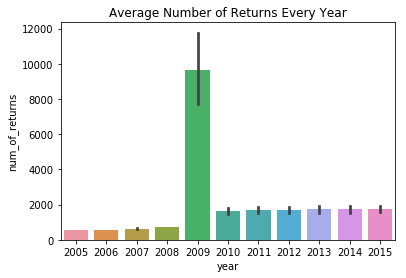

In [27]:
sns.barplot(data=raw_data, x='year', y='num_of_returns')
plt.title('Average Number of Returns Every Year')

Text(0.5,1,'Total Number of Returns Every Year')

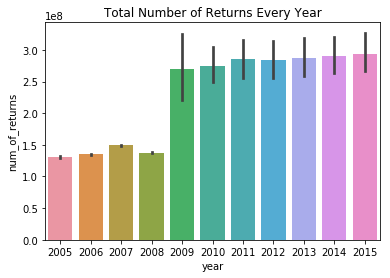

In [15]:
sns.barplot(data=raw_data, x='year', y='num_of_returns', estimator=np.sum)
plt.title('Total Number of Returns Every Year')

This is very interesting since the number of returns should not change so dramatically. It might be something hidden in the data. 

Text(0.5,1,'Total Data Collected Each Year')

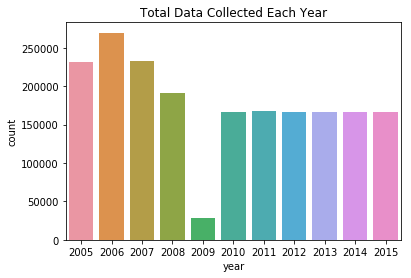

In [28]:
sns.countplot(data=raw_data, x='year')
plt.title('Total Data Collected Each Year')

This explans the sky-high average number of return in 2009. Although the total amount of returns seems right, the data point is much less than the other years. After reading through the documents, I did not find any reasons why it is significantly less than the other years. I assume that many zipcodes were grouped together in 2009. 

Since there is no way to fix it, the plot with average number will not be approprite. The future plots will focus on total amount.

Put the 2009 issue aside, the total number of returns jumped almost twice from 2008 to 2009. Since there is no documents in IRS explained the possible reasons, I would assume this is because of the financial crisis. More people are filing returns to get tax refund or figuring out their situations because of the financial crisis. After 2009, the total amount increased slightly each year.

### Paid Preparer

Text(0.5,1,'Total Number of People using Paid Preparer Every Year')

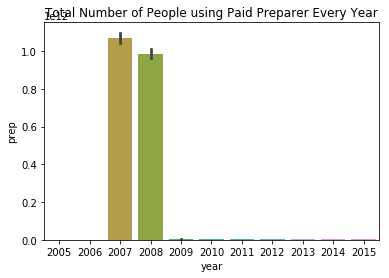

In [17]:
sns.barplot(data=raw_data, x='year', y='prep', estimator=np.sum)
plt.title('Total Number of People using Paid Preparer Every Year')

In [18]:
prep = pd.pivot_table(raw_data, values='prep', 
                      index=['year'], columns=['state'], aggfunc=np.sum, margins=True)

In [19]:
prep['All']

year
2005    7.964807e+07
2006    8.222484e+07
2007    1.070869e+12
2008    9.871033e+11
2009    1.763429e+09
2010    1.939648e+09
2011    2.073536e+09
2012    2.335302e+09
2013    2.410683e+09
2014    2.665880e+09
2015    2.826148e+09
All     2.074149e+12
Name: All, dtype: float64

If the original dataset doesn't contain errors, 2007 and 2008 have significantly more people using a paid preparer than other years. It might related to the economical prosperity in these two years.

### Number of People who used Itemized Deduction

Text(0.5,1,'Total Number of Returns with Itemized Deduction')

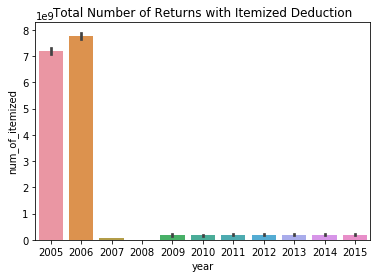

In [20]:
sns.barplot(data=raw_data, x='year', y='num_of_itemized', estimator=np.sum)
plt.title('Total Number of Returns with Itemized Deduction')

Similar to number of paid preparer, 2005 and 2006 have more returns with itemized deduction than other years. 2009-2015 are more consistent.

### Adjusted Gross Income

Text(0.5,1,'Total AGI Every Year')

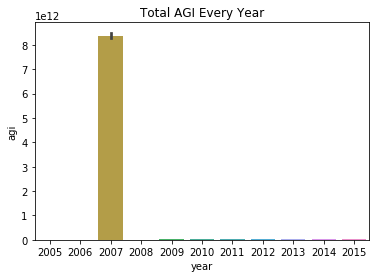

In [21]:
sns.barplot(data=raw_data, x='year', y='agi', estimator=np.sum)
plt.title('Total AGI Every Year')

Text(0.5,1,'Average AGI Every Year')

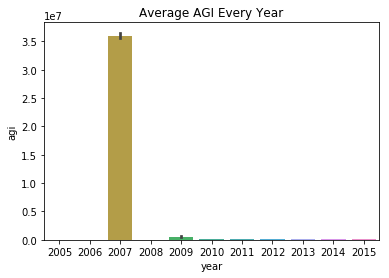

In [22]:
sns.barplot(data=raw_data, x='year', y='agi')
plt.title('Average AGI Every Year')

2007 has much higher agi amount than the rest of the years regardless of total amount or average amount. Based on previous visualization, 2009-2015 have more consistent data. Let's see what will they show.

Text(0.5,1,'Average AGI from 2009-2015')

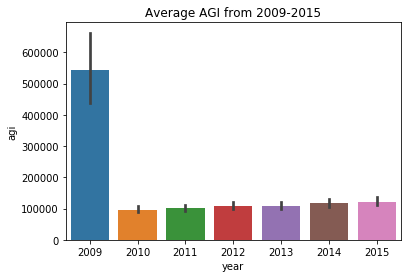

In [23]:
sns.barplot(data=raw_data[(raw_data['year'] >= 2009) & (raw_data['year'] <= 2015)],
            x='year', y='agi')
plt.title('Average AGI from 2009-2015')

Text(0.5,1,'Total AGI from 2009-2015')

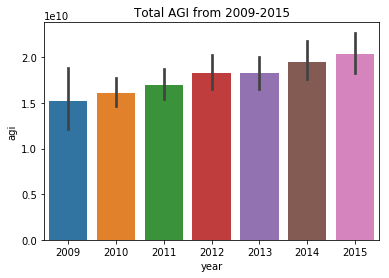

In [24]:
sns.barplot(data=raw_data[(raw_data['year'] >= 2009) & (raw_data['year'] <= 2015)],
            x='year', y='agi', estimator=np.sum)
plt.title('Total AGI from 2009-2015')

This is more reasonable and consistent. 2009 has much higher average since the total amount of data is significantly lower as shown previously. The average agi increases slightly every year since 2009.

### Total Amount of Tax

Text(0.5,1,'Total Tax Amount on Returns Every Year')

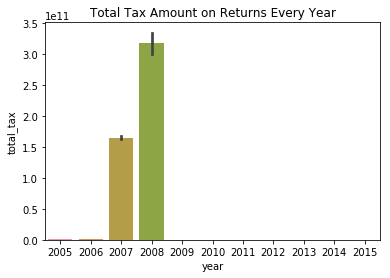

In [25]:
sns.barplot(data=raw_data, x='year', y='total_tax', estimator=np.sum)
plt.title('Total Tax Amount on Returns Every Year')

Text(0.5,1,'Total Tax Amount on Returns 2009-2015')

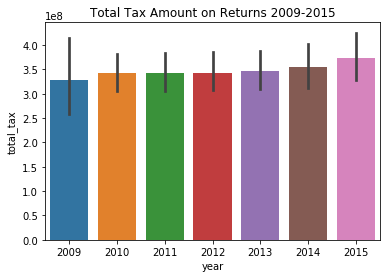

In [26]:
sns.barplot(data=raw_data[(raw_data['year'] >= 2009) & (raw_data['year'] <= 2015)],
            x='year', y='total_tax', estimator=np.sum)
plt.title('Total Tax Amount on Returns 2009-2015')

Similar to agi amount, 2007 and 2008 has unexpected high amount than the other years. 2009 to 2015 have more consistent amount. The total tax per return increased slightly every year, which is similar to agi amount>

## Univariate Analysis

After concatenate the 10 year tax data, there are 1,953,802 rows in total with 16 total variables. The above analysis shows some issues with original dataset. Data is not well collected in 2009. The total amount of data in 2009 is significantly less than that of the other years. 2005 to 2008 data is not consistent with the other year, they has unreasonable higher amount than the other years.

Since the goal of the model is to predict the tax due in current year and in the future, the chaos in the 2005-2008 data could do more harm than good. I will use both the whole dataset and the 2009 (or 2010 since 2009 doesn't have enough data) to 2015 data to train the model separately to see which one is better.